In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

# from sklearn import gaussian_process
# from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

In [4]:
from scipy.interpolate import PchipInterpolator

In [35]:
# https://dsp.stackexchange.com/questions/1676/savitzky-golay-
#smoothing-filter-for-not-equally-spaced-data

def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/
    savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

def return_arr_to_orig(time_array):
    return_arr = []
    orig_time = savgol_filtered_oband['mjd']-mjd_scale
    for datapt in time_array:
        matched_time_ind = np.argmin(np.abs(orig_time-datapt))
        return_arr.append(orig_time[matched_time_ind])
    return_arr = np.asarray(return_arr)
    return return_arr

def err_calculation(time_arr):
    orig_time = savgol_filtered_oband['mjd']-mjd_scale
#     print(len(orig_time))
    err_arr = []
    for time in time_arr:
        matched_time_ind = np.argmin(np.abs(orig_time-time))
#         print(matched_time_ind)
        if matched_time_ind != 0 and matched_time_ind > 5 and matched_time_ind < (len(orig_time)-6):
#             print((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
            err_arr.append((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
        elif matched_time_ind > (len(orig_time)-6):
#             print('end of arr')
            err_arr.append(0)
        else:
#             print('beginning of arr')
            err_arr.append(0)
    err_arr = np.asarray(err_arr)
    return err_arr

In [40]:

def decline_detection(data_frame,min_decline_depth=0.9,saturation_limit=12,use_iter_smooth=False,debug_mode=False):
    ##############################################
    ## note that the DataFrame must have a 'jd' column and a 'mag' column
    ##############################################

    ##############################################
    ## zeropoint so we don't have to do it forever
    ##############################################
    mjd_scale = data_frame['jd'][0]

    ##############################################
    ## apply a savgol filter to remove outliers
    ##############################################
    ### will fail if duplicate data points
    savgol_filtered = non_uniform_savgol(np.asarray(data_frame['jd']-mjd_scale),
                                         np.asarray(data_frame['mag']),
                                       window=7, polynom=1)
    
    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd']-mjd_scale,data_frame['mag'],s=10,
                    c=savgol_filtered-data_frame['mag'],cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('magnitude')
        plt.colorbar(label='savgol residual')
        plt.title('Savgol residual on original data')
        # plt.clim(vmax=-1)
        plt.clim(vmin=-2)
        plt.show()

    ## measure the std deviation of the savgol filtering
    ## we will kick out data points with residuals bigger than this
    deviation = np.std(savgol_filtered-data_frame['mag'])
    if debug_mode==True:
        print('Std dev:',deviation)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd']-mjd_scale,savgol_filtered-data_frame['mag'],s=10)
        plt.axhline(deviation,color='k',linestyle='--')
        plt.axhline(-deviation,color='k',linestyle='--')
        # plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('residuals to savgol filter')
        plt.title('savgol filter residuals with the cutoff labelled')
        plt.ylim(-1,1)
        plt.show()

    ## the actual mask for the savgol filtering
    mask = np.where(np.abs(savgol_filtered-data_frame['mag'])<deviation,True,False)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(data_frame['jd'][mask]-mjd_scale,data_frame['mag'][mask],s=10)
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('magnitude')
        plt.title('Savgol filtered data')
        plt.show()

    ## apply the mask for savgol filtering
    savgol_filtered_frame = data_frame.iloc[mask]
    savgol_filtered_frame.reset_index(drop=True,inplace=True)
    # savgol_filtered_oband

    ##############################################
    ## savgol filter to smooth the data
    ##############################################
    ## make another, more aggressive savgol filter to smooth the data
    iter_savgol_filtered = non_uniform_savgol(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                         np.asarray(savgol_filtered_frame['mag']),
                                       window=31, polynom=1)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],s=10,
                    c=iter_savgol_filtered-savgol_filtered_frame['mag'],cmap='bwr')
        plt.colorbar(label='iterated savgol residual')
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,iter_savgol_filtered,s=10,alpha=0.5)
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('savgol filtered magnitude')
        plt.title('Savgol for smoothing (iter)')
        plt.show()

    ##############################################
    ## create a mask for the regions which are saturated
    ## this will need to be edited for things that aren't ATLAS
    ##############################################
    # I think we can use that ATLAS saturates at around 11 mag # r ~ 12.5
    # and limiting mag is ~20
    local_std = np.std((iter_savgol_filtered-savgol_filtered_frame['mag']))
#     saturation_limit = 0#12
    saturation_mask = []
    halfwidth=5
    for i in range(0,len(iter_savgol_filtered)):
        if i > len(iter_savgol_filtered)-halfwidth:
            saturation_mask.append(True)
        elif i < halfwidth:
            saturation_mask.append(True)
        else:
            variation_window = np.max(np.abs(iter_savgol_filtered[i-halfwidth:i+halfwidth]-savgol_filtered_frame['mag'][i-halfwidth:i+halfwidth]))
            if variation_window > 0.1 and np.mean(savgol_filtered_frame['mag'][i-halfwidth:i+halfwidth])<saturation_limit:
        #         print('mask me')
                saturation_mask.append(False)
            else:
                saturation_mask.append(True)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],s=10,alpha=0.5)
        plt.scatter(savgol_filtered_frame['jd'][saturation_mask]-mjd_scale,savgol_filtered_frame['mag'][saturation_mask],s=10,
                    c=iter_savgol_filtered[saturation_mask]-savgol_filtered_frame['mag'][saturation_mask],cmap='bwr')
        # plt.scatter(savgol_filtered_frame['jd'][np.invert(saturation_mask)]-mjd_scale,
        #            saturation_replace[np.invert(saturation_mask)],color='darkgrey')
        plt.colorbar(label='iterated savgol residual')
        # plt.scatter(savgol_filtered_frame['jd']-mjd_scale,iter_savgol_filtered,s=10,alpha=0.5)
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('savgol filtered magnitude')
        # plt.colorbar(label='iterated savgol residual')
        # plt.clim(vmax=-1)
        # plt.clim(vmin=-2)
        plt.show()



    ##############################################
    ## decide on the iter smooth or the original data
    ##############################################
    if use_iter_smooth==True:
        savgol_filtered_frame['mag'] = iter_savgol_filtered


    ##############################################
    ## interpolate the data to get evenly sampled data
    ##############################################
    # interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
    #                                                  np.asarray(iter_savgol_filtered),
    #                                                  kind='linear')
    interpolation_function = sp.interpolate.interp1d(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
                                                     np.asarray(savgol_filtered_frame['mag']),
                                                     kind='linear')

    ### attempting monotone interpolants ###
    # interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
    #                                                  np.asarray(iter_savgol_filtered)) # this one is better
    # interpolation_function = PchipInterpolator(np.asarray(savgol_filtered_frame['jd']-mjd_scale),
    #                                                  np.asarray(savgol_filtered_frame['mag'])) # this one is better


    ## what time resolution? I don't want to lose any of the real data if possible
    real_resolution = np.median(np.diff(savgol_filtered_frame['jd']))
    len_data = np.max(savgol_filtered_frame['jd']-mjd_scale)
    resample_time = np.linspace(0,len_data,int(len_data))#int(len_data/(real_resolution/10000)))
    ## currently resampling at a resolution of 1 day
    resample_flux = interpolation_function(resample_time)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10)
        plt.scatter(np.asarray(savgol_filtered_frame['jd']-mjd_scale),np.asarray(iter_savgol_filtered),s=10)
        plt.scatter(np.asarray(savgol_filtered_frame['jd']-mjd_scale),np.asarray(savgol_filtered_frame['mag']),s=10)
        plt.gca().invert_yaxis()
        plt.xlabel('resampled jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.title('checking the interpolation method with the smooth/orig data')
        # plt.ylim(20.5,11)
        # plt.ylim(14,11)
        # plt.xlim(1000,1200)
        plt.show()

    ##############################################
    ## edge detection via convolution
    ##############################################
    new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,new_edge_detect,s=10)
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('edge detection')
        plt.title('edge detection via convolution')
        # plt.ylim(-1,1)
        plt.show()

        plt.figure(figsize=(14,6))
        # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
        plt.scatter(resample_time,resample_flux,s=10,
                    c=new_edge_detect,cmap='bwr')#,alpha=0.2)
        # plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
        plt.gca().invert_yaxis()
        plt.xlabel('resampled jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='edge detect')
        plt.clim(-0.1,0.1)
        plt.title('plotting edge detection via convolution on the original data')
        plt.show()

    ##############################################
    ## creating a mask for when edge detect is positive
    ##############################################
    # std_dev = np.std(new_edge_detect)
    # # std_dev
    # new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
    new_mask = np.where(np.abs(new_edge_detect)>0,True,False)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        # plt.scatter(data_frame['jd'][mask]-mjd_scale,(gp_edges+3)*4,s=10)
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[new_mask],resample_flux[new_mask],s=10,
                    c=new_edge_detect[new_mask],cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='edge detect')
        plt.title('positive in edge detection via convolution')
        plt.clim(-0.1,0.1)
        # plt.xlim(950,1200)
        # plt.xlim(500,1000)
        plt.show()

    ##############################################
    ## create mask for edge detection significantly positive
    ##############################################
    std_dev = np.std(new_edge_detect)
    new_mask = np.where(np.abs(new_edge_detect)>(std_dev*0.25),True,False)
    downslope_mask = np.where(new_edge_detect>0.0,True,False)
    total_mask = new_mask & downslope_mask

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        # plt.scatter(data_frame['jd'][mask]-mjd_scale,(gp_edges+3)*4,s=10)
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                    c=new_edge_detect[total_mask],cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.title('masked for edge detection significantly positive')
        plt.colorbar(label='edge detect')
        plt.clim(-0.1,0.1)
        # plt.xlim(950,1200)
        # plt.xlim(500,1000)
        plt.show()

    ##############################################
    ## edge detection via gradients
    ##############################################
    gradient = np.gradient(resample_flux, resample_time)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,gradient,s=10)
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('gradient')
        plt.title('the gradient')
        plt.ylim(-0.25,0.25)
        plt.show()

        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,gradient-new_edge_detect,s=10)
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('diff between gradient and convolution edges')
        plt.ylim(-0.25,0.25)
        plt.show()

        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,
                    c=gradient,cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('edge detection via the gradient')
        plt.clim(-0.1,0.1)
        plt.show()

    ##############################################
    ## mask for where gradient is positive
    ##############################################
    downslope_mask = np.where(gradient>0,True,False)
    total_mask = downslope_mask

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[downslope_mask],resample_flux[downslope_mask],s=10,
                    c=gradient[downslope_mask],cmap='bwr')
        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('positive gradient mask')
        plt.clim(-0.1,0.1)
        plt.show()

    ##############################################
    ## find the runs of positive and negative values
    ##############################################
    run_vals, run_start, run_length = find_runs(total_mask)

    downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
    upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

    ## generation of the actual decline onsets
    ## this is the meat of the code
    if debug_mode==True:
        print('actually detecting the declines')
#     decline_min_depth = 0.9
    decline_onset = []
    decline_end = []
    decline_depth = []
    for i in range(0,len(resample_flux[run_start])):
        if i == 0 and np.abs(resample_flux[0] - resample_flux[run_start[i+1]]) > decline_min_depth:
            ## adding the absolute magnitude should detect beginning declines
            ## NEEDS TO BE TESTED
            decline_onset.append(0)
            if debug_mode==True:
                print('beginning')
                print('0')
                print(resample_flux[0])
                print(np.abs(resample_flux[0] - resample_flux[run_start[i]]))
            decline_end.append(run_start[i+1])
            decline_depth.append(np.abs(resample_flux[0] - resample_flux[run_start[i+1]]))
        elif i == len(resample_flux[run_start])-1:
            if resample_flux[-1] - resample_flux[run_start[i]] > decline_min_depth:
                decline_onset.append(run_start[i])
                if debug_mode==True:
                    print('end')
                    print(run_start[i])
                    print(resample_flux[run_start[i]])
                    print(resample_flux[-1] - resample_flux[run_start[i]])
                decline_end.append(len(resample_flux)-1)
                decline_depth.append(resample_flux[-1] - resample_flux[run_start[i]])
        elif resample_flux[run_start[i+1]] - resample_flux[run_start[i]] > decline_min_depth:#1:
            decline_onset.append(run_start[i])
            if debug_mode==True:
                print(run_start[i])
                print(resample_flux[run_start[i]])
                print(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
            decline_end.append(run_start[i+1])
            decline_depth.append(resample_flux[run_start[i+1]] - resample_flux[run_start[i]])
    #     if i == len(resample_flux[run_start]):
    #         print('end')
    if debug_mode==True:
        print(resample_flux[decline_end])
        print(decline_depth)

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[downward_mask],
                    np.full(len(resample_time[downward_mask]),np.min(resample_flux))-0.2,
                    s=20,marker='x',color='k',zorder=3)
        plt.scatter(resample_time[upward_mask],
                    np.full(len(resample_time[upward_mask]),np.min(resample_flux))-0.2,
                            s=20,marker='x',color='tab:green',zorder=3)
        plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                    c=(gradient[total_mask]),cmap='bwr')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.clim(-0.1,0.1)
        plt.title('all the original run masks')
        plt.show()

        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,resample_flux,s=10,color='lightgrey')
        plt.scatter(resample_time[decline_onset],
                    np.full(len(resample_time[decline_onset]),np.min(resample_flux))-0.2,
                            s=20,marker='x',color='k',zorder=3)
        plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                    c=(gradient[total_mask]),cmap='bwr')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('interpolated magnitude')
        plt.colorbar(label='gradient')
        plt.title('the better run masks with the gradient mask')
        plt.clim(-0.1,0.1)
        plt.show()

    ## more of the meat here
    ## turning the masks into real data points
    plt.figure(figsize=(14,6))
    plt.scatter(resample_time,resample_flux,s=10,color='lightsteelblue')
    plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],
                s=10,color='darkgrey')
    plt.scatter(resample_time[total_mask],resample_flux[total_mask],s=10,
                c=(gradient[total_mask]),cmap='bwr',alpha=0.2)
    plt.clim(-0.1,0.1)

    onset_arr = []
    onset_flag = []
    max_depth_arr = []
    end_arr = []
    end_flag = []

    max_light = np.min(resample_flux)
    plt.axhline(max_light,color='k',linestyle='--')
    plt.axhline(max_light+decline_min_depth,color='k',linestyle='--',alpha=0.5)
    for i in range(0,len(resample_time[decline_onset])):
        flag_set = False
        if decline_onset[i] == 0:
    #         print('beginning of array')
            onset_flag.append(1)
            flag_set = True
        onset_time = resample_time[decline_onset][i]
        diff_arr = np.abs((savgol_filtered_frame['jd'][saturation_mask]-mjd_scale)-onset_time)
        if np.min(diff_arr) > 5:
            if decline_depth[i] > decline_min_depth:#12-np.min(savgol_filtered_frame['mag']):
                plt.axvline(onset_time,color='red',linestyle='--')
                plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
    #             plt.axhline(max_light+decline_min_depth+decline_depth[i],color='k',linestyle='--')
                onset_arr.append(onset_time)
                max_depth_arr.append(resample_time[decline_end[i]])
                if flag_set == False:
                    onset_flag.append(2)
    #             print('onset', onset_time)
            else:
    #             print('bad onset')
                onset_flag.append(3)
                onset_arr.append(onset_time)
                max_depth_arr.append(resample_time[decline_end[i]])
                pass
    #             plt.axvline(onset_time,color='red',linestyle='--')
        else:
            plt.axvline(onset_time,color='green',linestyle='--',alpha=0.5)
            plt.axvline(resample_time[decline_end[i]],color='grey',linestyle='--',alpha=0.5)
    #         plt.axhline(max_light+decline_min_depth+decline_depth[i],linestyle='--')
            if flag_set == False:
                onset_flag.append(0)
            onset_arr.append(onset_time)
            max_depth_arr.append(resample_time[decline_end[i]])
    #         print('onset', onset_time)

        post_decline_time = resample_time[resample_time>onset_time]
        post_decline_flux = resample_flux[resample_time>onset_time]
        xx = 0
        while post_decline_flux[xx] < (max_light+decline_min_depth):
            xx=xx+1
        else:
    #         print('exited max light')
            exit_time = post_decline_time[xx]
            post_decline_time = resample_time[resample_time>exit_time]
            post_decline_flux = resample_flux[resample_time>exit_time]

        xx = 0
        try:
            while post_decline_flux[xx] > (max_light+decline_min_depth):
                xx=xx+1
            else:
    #             print('reached max light')
    #             print(xx,post_decline_flux[xx],post_decline_time[xx])
                plt.axvline(post_decline_time[xx],color='blue',linestyle='--',alpha=0.5)
                end_arr.append(post_decline_time[xx])
                end_flag.append(0)
        except IndexError:
    #         print('reached end of array')
    #         print(xx-1,post_decline_flux[xx-1],post_decline_time[xx-1])
            plt.axvline(post_decline_time[xx-1],color='blue',linestyle='--',alpha=0.5)
            end_arr.append(post_decline_time[xx-1])
            end_flag.append(1)

    # print(onset_arr)
    # print(onset_flag)
    # print(end_arr)
    # print(end_flag)
    # print(max_depth_arr)

    plt.scatter(resample_time[decline_onset][np.asarray(onset_flag) != 3],
                np.full(len(resample_time[decline_onset][np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.2,
                        s=20,marker='x',color='k',zorder=3)

    for i in range(0,len(onset_arr)):
        if onset_flag[i] != 3:
            plt.axvspan(onset_arr[i], end_arr[i], alpha=0.1, color='grey')

    plt.gca().invert_yaxis()
    plt.xlabel('jd - '+str(mjd_scale))
    plt.ylabel('savgol filtered magnitude')
    plt.title('setting the onsets and the flags')
    plt.show()

    ## resample the times back to the original data set
    orig_time = savgol_filtered_frame['jd']-mjd_scale
    onset_arr_orig = return_arr_to_orig(onset_arr)
    end_arr_orig = return_arr_to_orig(end_arr)
    depth_time_orig = return_arr_to_orig(max_depth_arr)

    ## calculate errors
    onset_err_arr = err_calculation(onset_arr_orig)
    end_err_arr = err_calculation(end_arr_orig)
    depth_err_arr = err_calculation(depth_time_orig)

    # ## time error calculations based on how many data points are around
    # err_arr = []
    # for onset in onset_arr_orig:
    #     matched_time_ind = np.argmin(np.abs(orig_time-onset))
    #     if matched_time_ind != 0 and matched_time_ind > 5:
    #         print((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
    #         err_arr.append((orig_time[matched_time_ind+5]-orig_time[matched_time_ind-5])/2)
    #     else:
    #         print('beginning of arr')
    #         err_arr.append(0)
    # err_arr = np.asarray(err_arr)

    ## plot the errorbars
    plt.figure(figsize=(14,6))
    plt.scatter(savgol_filtered_frame['jd']-mjd_scale,savgol_filtered_frame['mag'],
                s=10,color='darkgrey')

    plt.errorbar(x=onset_arr_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0.4,
                 xerr=onset_err_arr[np.asarray(onset_flag) != 3],fmt='o')

    plt.errorbar(x=end_arr_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(end_arr_orig[np.asarray(onset_flag) != 3]),np.min(resample_flux))-0,
                 xerr=end_err_arr[np.asarray(onset_flag) != 3],fmt='o')

    plt.errorbar(x=depth_time_orig[np.asarray(onset_flag) != 3],
                y=np.full(len(depth_time_orig[np.asarray(onset_flag) != 3]),np.max(resample_flux))+0.4,
                 xerr=depth_err_arr[np.asarray(onset_flag) != 3],fmt='o')


    for onset_time in onset_arr_orig[np.asarray(onset_flag) != 3]:
        plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')

    for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
        plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')

    for i in range(0,len(onset_arr_orig)):
        if onset_flag[i] != 3:
            plt.axvspan(onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')

    plt.gca().invert_yaxis()
    plt.xlabel('jd - '+str(mjd_scale))
    plt.ylabel('savgol filtered magnitude')
    plt.title('showing the errors on the all of the times')
    plt.show()

    if debug_mode==True:
        plt.figure(figsize=(14,6))
        plt.scatter(resample_time,gradient,s=10,color='tab:red')
        plt.scatter(onset_arr_orig[np.asarray(onset_flag) != 3],
                    np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),0),
                            s=20,marker='x',color='k',zorder=3)

        plt.errorbar(x=onset_arr_orig[np.asarray(onset_flag) != 3],
                    y=np.full(len(onset_arr_orig[np.asarray(onset_flag) != 3]),0),
                     xerr=onset_err_arr[np.asarray(onset_flag) != 3],fmt='o')

        for onset_time in onset_arr_orig[np.asarray(onset_flag) != 3]:
            plt.axvline(onset_time,color='green',alpha=0.5,linestyle='--')
        for end_time in end_arr_orig[np.asarray(onset_flag) != 3]:
            plt.axvline(end_time,color='blue',alpha=0.5,linestyle='--')

        for i in range(0,len(onset_arr_orig)):
            if onset_flag[i] != 3:
                plt.axvspan(onset_arr_orig[i], end_arr_orig[i], alpha=0.1, color='grey')

        plt.gca().invert_yaxis()
        plt.xlabel('jd - '+str(mjd_scale))
        plt.ylabel('gradient')
        plt.title('the gradient and the errors')
        # plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
        plt.show()


    ##############################################
    ## save all the data in a dataframe
    ##############################################
    decline_arr = np.array([onset_arr_orig,onset_err_arr,onset_flag,
                            end_arr_orig,end_err_arr,end_flag,
                            depth_time_orig,depth_err_arr,
                            decline_depth,resample_flux[decline_end]])
    decline_frame = pd.DataFrame(decline_arr.T,
                                 columns=['onset_time','onset_err','onset_flag','end_time','end_err',
                                          'end_flag','depth_time','depth_err','decline_depth','min_mag'])
    if debug_mode==True:
        print(decline_frame)
    return decline_frame

In [6]:
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-21_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_ASAS-RCB-7_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-11-07_EROS2-CG-RCB-10_ATLAS.csv')
atlas

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.728,0.002,29433.0,73.0,o,0,124.82,295.57658,-20.54653,2602.82,553.77,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4611,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o
4612,60085.289962,15.891,0.012,1597.0,20.0,o,0,7.68,295.57660,-20.54654,3483.49,4412.50,2.05,1.87,84.7,-0.423,19.29,20.65,04a60085o0743o
4613,60093.044580,18.811,0.103,108.0,11.0,c,0,1.20,295.57660,-20.54654,9278.83,6021.04,2.94,2.75,-33.6,-0.361,19.45,21.42,03a60093o0736c
4614,60093.047335,18.616,0.090,130.0,12.0,c,0,1.13,295.57660,-20.54654,9261.36,5982.77,2.91,2.67,-25.9,-0.358,19.48,21.42,03a60093o0742c


In [8]:
oband = atlas[atlas['f']=='o']
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.727,0.002,29461.0,73.0,o,0,121.64,295.57660,-20.54654,2602.78,553.75,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
1789,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
1790,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
1791,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


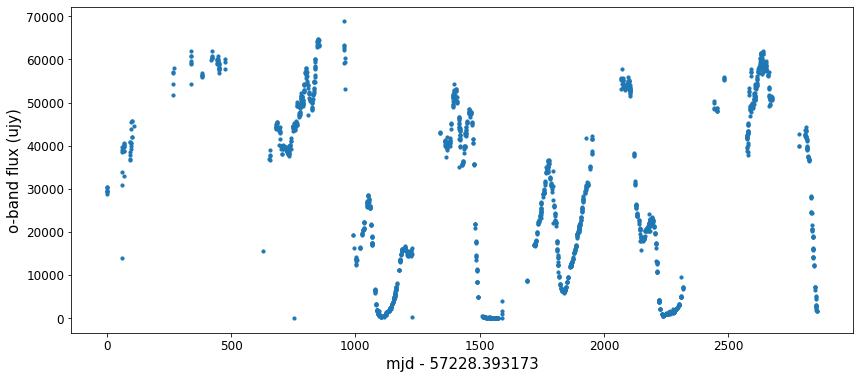

In [10]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['ujy'],s=10)#/(80000),s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band flux (ujy)')
# plt.ylim(-100,1000)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

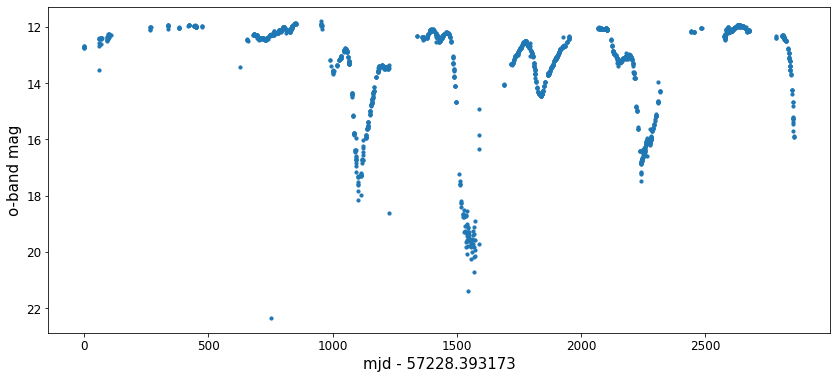

In [9]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)#/(80000),s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band mag')
# plt.ylim(top=1.2)
# plt.ylim(0.6,1.2)
# plt.xlim(1000,2000)
plt.show()

In [23]:
oband.rename(columns={'mjd': 'jd', 'm': 'mag'},inplace=True)


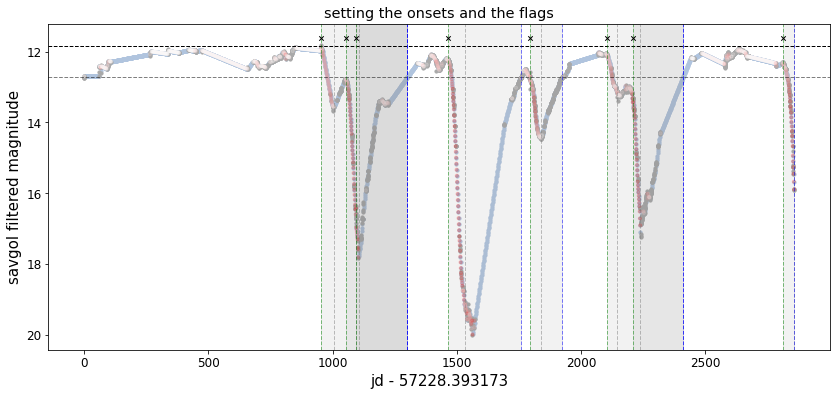

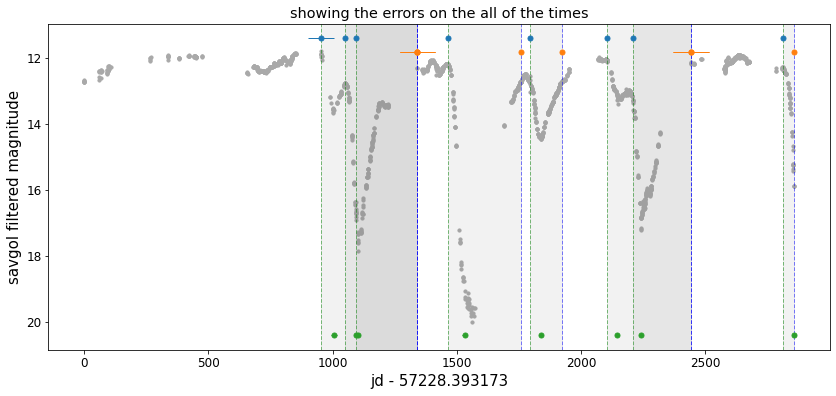

,onset_time,onset_err,onset_flag,end_time,end_err,end_flag,depth_time,depth_err,decline_depth,min_mag
0,955.238601,52.219207,0.0,1341.239220,69.696855,0.0,1005.180093,12.964531,1.698038,13.564618
1,1051.128256,5.983066,0.0,1341.239220,69.696855,0.0,1093.039296,1.977752,3.839770,16.612395
2,1094.984282,5.007002,0.0,1341.239220,69.696855,0.0,1103.022992,6.959856,1.342036,17.765616
3,1463.024128,4.917581,0.0,1757.168041,5.464832,0.0,1530.944277,10.962977,6.874880,19.078609
4,1795.015133,5.423974,0.0,1922.853333,6.989294,0.0,1839.079701,6.023537,1.754993,14.439414
5,2104.235882,7.960253,0.0,2442.222787,71.688562,0.0,2145.099461,6.483436,1.075288,13.157090
6,2209.067432,2.040160,0.0,2442.222787,71.688562,0.0,2238.948159,6.000354,3.694763,17.108929
7,2811.982280,2.632026,0.0,2856.896789,0.000000,1.0,2856.896789,0.000000,3.569439,15.891000


In [42]:
decline_detection(oband)#,min_decline_depth=0.9,saturation_limit=12,use_iter_smooth=False,debug_mode=False)